# The Intergrated Gradient Differentials
### of the nl-BERT-large Model Prior to and Post Fine-tuning

In this notebook we calculate the intergrated gradient (IG) differentials of the nl-BERT-large Model Prior to and Post Fine-tuning. The IG values for the two models are extracted in the `ÌG_nbl_FT.ipynb` and `ÌG_pretrained.ipynb` notebooks. 

In [ ]:
#### Install packages:
!pip install -q pandas json pathlib matplotlib

### Loading in the IG values
To this a function has been created that loops over all the `.json` files containing IG values from each of the models:

In [3]:
import pandas as pd
import json
from pathlib import Path

def load_json_to_dataframe(directory_path):
    # List all .json files in the directory sorted by batch number
    json_files = sorted(Path(directory_path).glob('IG_values_batch_*.json'), key=lambda x: int(x.stem.split('_')[-1]))

    df = pd.DataFrame(columns=['token', 'value', 'text_idx'])
    text_idx_counter = 0

    # Flattening JSON content and add text index
    def flatten_json(json_content, text_idx_start):
        flattened = []
        for text_idx, sublist in enumerate(json_content, start=text_idx_start):
            for pair in sublist:
                flattened.append((pair[0], pair[1], text_idx))
        return flattened

    # Loop through all .json files and append their content to the DataFrame
    for json_file in json_files:
        # Open and load the json file
        with open(json_file, 'r') as file:
            json_content = json.load(file)

        # Flattening the JSON content and add text index
        flattened_data = flatten_json(json_content, text_idx_counter)

        # Updating the text index counter (add the number of texts in the current batch)
        text_idx_counter += len(json_content)

        # Creating a DataFrame from the flattened data and append
        temp_df = pd.DataFrame(flattened_data, columns=['token', 'value', 'text_idx'])
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

In [4]:
#### finetuned:
pt_path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/IG/pretrained_IG_outputs'
pt_df = load_json_to_dataframe(pt_path)
#### pretrained:
ft_path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/IG/IG_outputs'
ft_df = load_json_to_dataframe(ft_path)

## Differentials by gender:
We seperate the IG values by gender to let them reflect seperatly what features (here tokens) let to the prediction of "female" and "male" respectively:

In [10]:
pre_class_repo = pd.read_csv('/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/PRETRAIN_NBL_df_classification_report.csv')
fine_class_repo = pd.read_csv('/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/NBL_df_classification_report.csv')

#fixing small differences
pre_class_repo['Predicted Labels'] = pre_class_repo['Predicted Labels'].replace({'Female': 'female', 'Male': 'male'})
pre_class_repo['True Labels'] = pre_class_repo['True Labels'].replace({'Female': 'female', 'Male': 'male'})
pre_class_repo['text_idx'] = pre_class_repo['text_inx']
fine_class_repo['text_idx'] = fine_class_repo['Unnamed: 0']

In [11]:
pred_df_merge = pd.merge(pt_df, pre_class_repo)
fine_df_merge = pd.merge(ft_df, fine_class_repo)

In [12]:
fem_pre_avg = pred_df_merge[pred_df_merge['Predicted Labels']=='female']
male_pre_avg = pred_df_merge[pred_df_merge['Predicted Labels']=='male']

fem_fine_avg = fine_df_merge[fine_df_merge['Predicted Labels']=='female']
male_fine_avg = fine_df_merge[fine_df_merge['Predicted Labels']=='male']

### Averaging on pos and neg values
All IG values of duplicated tokens are aggregated, but only if they have the same sign. In this way no values cancel out one another by averaging. 

In [17]:
def average_duplicates_with_count(df):
    # Categorize each row as 'negative' or 'positive' based on the 'value'
    df['category'] = df['value'].apply(lambda x: 'negative' if x < 0 else 'positive')
    # Group by 'token' and 'category', calculate the mean of 'value' and count the occurrences
    df_avg = df.groupby(['token', 'category']).agg(
        value=('value', 'mean'),
        n=('token', 'count')
    ).reset_index()

    return df_avg

In [ ]:
fem_pre_nodup = average_duplicates_with_count(fem_pre_avg)
fem_fine_nodup = average_duplicates_with_count(fem_fine_avg)
male_pre_nodup = average_duplicates_with_count(male_pre_avg)
male_fine_nodup = average_duplicates_with_count(male_fine_avg)

Now that duplicates of same sign has been aggregated we find the differentials by subtracting the values of the model prior to fine-tuning and post fine-tuning.

In [27]:
###### females pretrained vs. finetuned:######
fem_merged_df = pd.merge(fem_fine_nodup, fem_pre_nodup, on=['token', 'category'], suffixes=('_fine', '_pred'))

# Calculate the difference in 'value' between the two dataframes
fem_merged_df['value_diff'] = fem_merged_df['value_fine'] - fem_merged_df['value_pred']
fem_dif_avg_df = fem_merged_df[['token', 'category', 'value_diff']]

In [28]:
###### males pretrained vs. finetuned:######
male_merged_df = pd.merge(male_fine_nodup, male_pre_nodup, on=['token', 'category'], suffixes=('_fine', '_pred'))

# Calculate the difference in 'value' between the two dataframes
male_merged_df['value_diff'] = male_merged_df['value_fine'] - male_merged_df['value_pred']
male_dif_avg_df = male_merged_df[['token', 'category', 'value_diff']]

Then we identify the top 20 most extreme differentials for both males and females:

In [368]:
##### MAKING 
# FEMALES
fem_top_20_dif = fem_dif_avg_df.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=False).head(20)
fem_low_20_dif = fem_dif_avg_df.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=True).head(20)
fem_upside = fem_low_20_dif.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=False).head(20)

# MALES
male_top_20_dif = male_dif_avg_df.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=False).head(20)
male_low_20_dif = male_dif_avg_df.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=True).head(20)
male_upside = male_low_20_dif.sort_values(by='value_diff', key=lambda x: x.abs(), ascending=False).head(20)


## Visualization of differentials

In [396]:
import matplotlib.pyplot as plt

def addlabels_female(bars, label_fontsize):
    for bar in bars:
        label = f'{bar.get_width():.2f}'
        xpos = bar.get_width() - 0.05 * abs(bar.get_width()) if bar.get_width() > 0 else bar.get_width() + 0.05 * abs(bar.get_width())
        plt.text(xpos, bar.get_y() + bar.get_height() / 2, label, ha='right' if bar.get_width() > 0 else 'left', va='center', fontsize=label_fontsize, color='navy', fontweight='bold')

def addlabels_male(bars, label_fontsize):
    for bar in bars:
        label = f'{bar.get_width():.2f}'
        xpos = bar.get_width() - 0.05 * abs(bar.get_width()) if bar.get_width() > 0 else bar.get_width() + 0.05 * abs(bar.get_width())
        plt.text(xpos, bar.get_y() + bar.get_height() / 2, label, ha='right' if bar.get_width() > 0 else 'left', va='center', fontsize=label_fontsize, color='violet', fontweight='bold')

def create_shap_plot(df_female, df_male, path, main_title, title_size=20, label_size=20, top_n=20, ytick_labelsize=18):
    plt.rcParams['font.family'] = 'Georgia'
    top_female = df_female.sort_values(by='value_diff', ascending=False).head(top_n)
    top_male = df_male.sort_values(by='value_diff', ascending=False).head(top_n)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))

    # Plot for Female Data
    ax1 = plt.subplot(1, 2, 1)
    bars_female = ax1.barh(top_female['token'], top_female['value_diff'], color=top_female['value_diff'].apply(lambda x: '#f27cc1' if x >= 0 else 'violet'))
    addlabels_female(bars_female, 17)
    ax1.set_title('Predicted "female"', fontsize=title_size)
    ax1.set_yticklabels(top_female['token'], fontsize=ytick_labelsize)
    ax1.axvline(x=0, color='grey', linestyle='--')  # Center line at x = 0
  
    # Plot for Male Data
    ax2 = plt.subplot(1, 2, 2)
    bars_male = ax2.barh(top_male['token'], top_male['value_diff'], color=top_male['value_diff'].apply(lambda x: '#3c48d6' if x >= 0 else 'navy'))
    addlabels_male(bars_male, 17)
    ax2.set_title('Predicted "male"', fontsize=title_size)
    ax2.axvline(x=0, color='grey', linestyle='--')  
    ax2.set_yticklabels(top_male['token'], fontsize=ytick_labelsize)

    ax2.yaxis.set_ticks_position('right')

    fig.text(0.001, .5, 'Token', va='center', ha='center', rotation='vertical', fontsize=label_size)
    fig.text(0.5, (-0.03), 'Difference in averaged SHAP values', va='center', ha='center', rotation='horizontal', fontsize=label_size)

    plt.suptitle(main_title, fontsize=title_size+5)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show()

/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_17799/2226547154.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(top_female['token'], fontsize=ytick_labelsize)
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_17799/2226547154.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(top_male['token'], fontsize=ytick_labelsize)


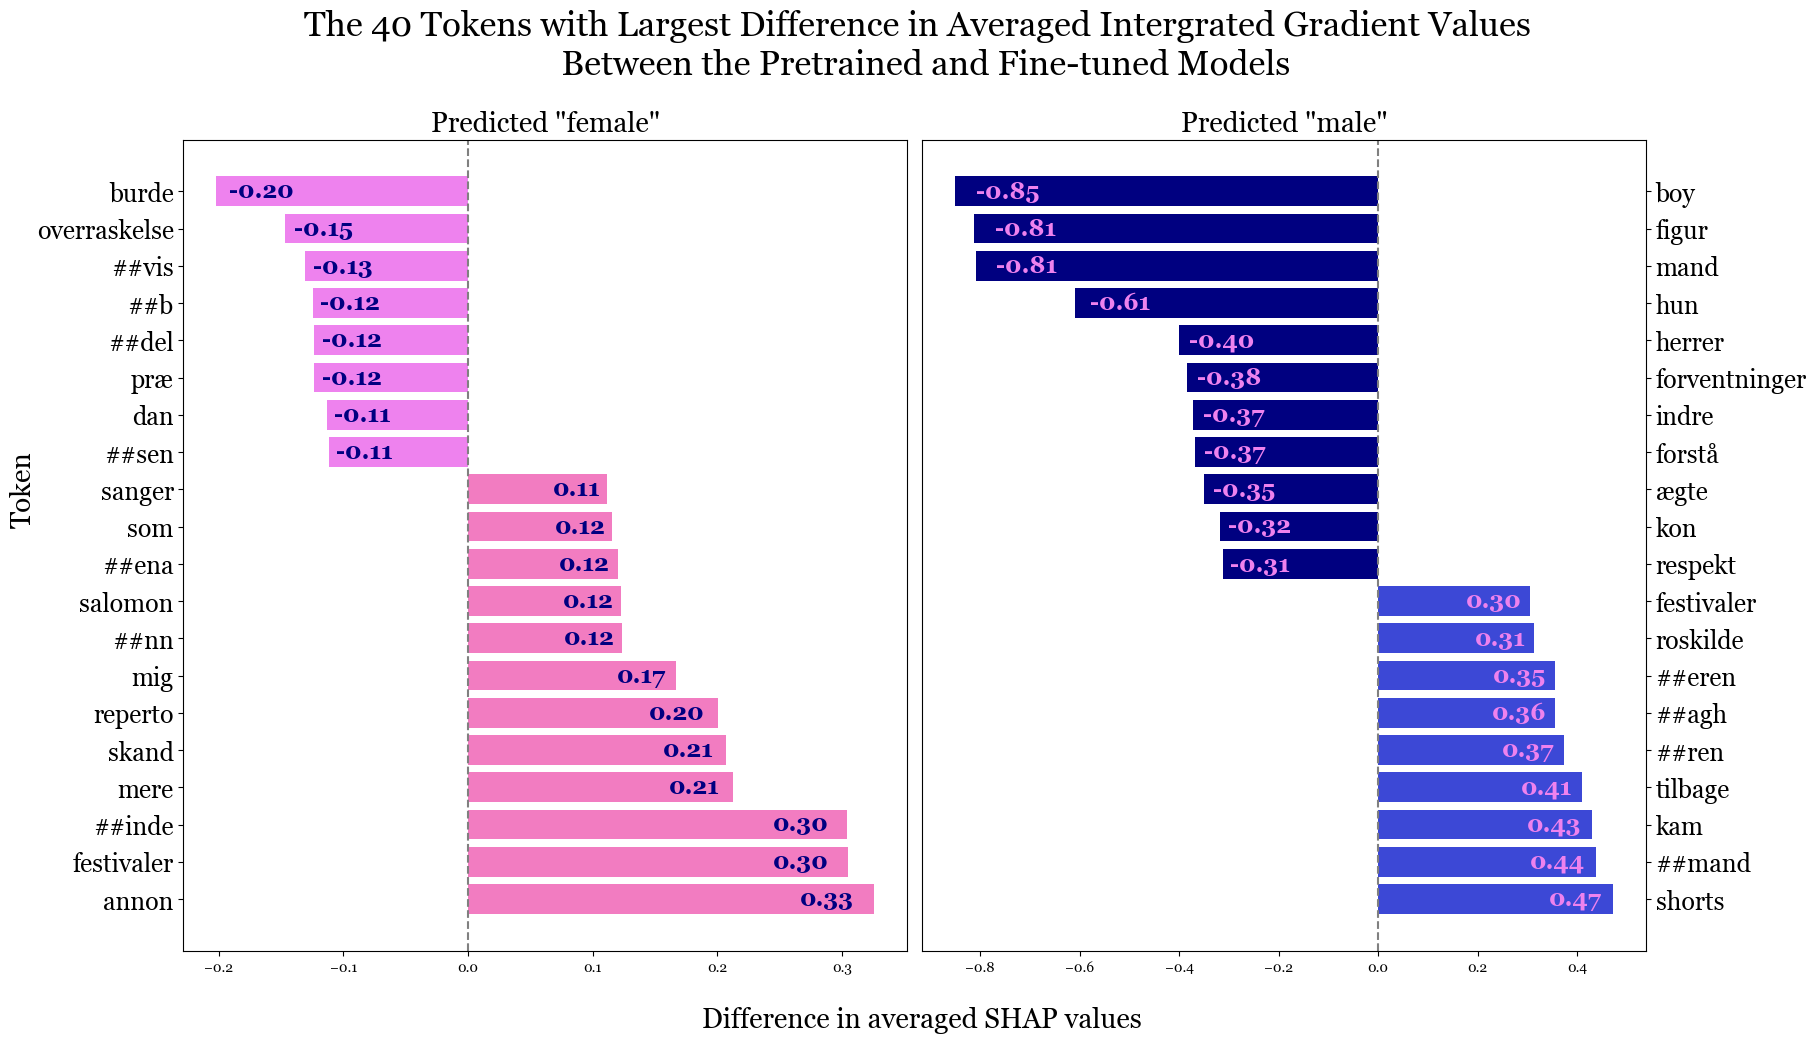

In [399]:
### finetuned::
path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/figures/differentials/fine_top_diff_gender.png'
create_shap_plot(fem_top_20_dif, male_top_20_dif, path, "The 40 Tokens with Largest Difference in Averaged Intergrated Gradient Values \n Between the Pretrained and Fine-tuned Models")

In [366]:
import matplotlib.pyplot as plt
import pandas as pd

def addlabels_positive(ax, bars, label_fontsize):
    for bar in bars:
        label = f'{bar.get_width():.2f}'
        # Offset the label to be inside the bar; more offset if the bar is very long
        offset = -0.01 * abs(bar.get_width()) if abs(bar.get_width()) > 0.05 else 0.01
        xpos = bar.get_width() - offset if bar.get_width() > 0 else bar.get_width() + offset
        ax.text(xpos, bar.get_y() + bar.get_height() / 2, label, ha='center', va='center', fontsize=label_fontsize, color='pink', fontweight='bold')

def addlabels_negative(ax, bars, label_fontsize):
    for bar in bars:
        label = f'{bar.get_width():.2f}'
        # Offset the label to be inside the bar; more offset if the bar is very long
        offset = 0.01 * abs(bar.get_width()) if abs(bar.get_width()) > 0.05 else 0.01
        xpos = bar.get_width() + offset if bar.get_width() < 0 else bar.get_width() - offset
        ax.text(xpos, bar.get_y() + bar.get_height() / 2, label, ha='center', va='center', fontsize=label_fontsize, color='violet', fontweight='bold')


def create_shap_plot(df_male, df_female, path, main_title, title_size=20, label_size=20, top_n=20, ytick_labelsize=18):
    plt.rcParams['font.family'] = 'Georgia'
    positive_values = pd.concat([df_male[df_male['value_diff'] > 0], df_female[df_female['value_diff'] > 0]]).sort_values(by='value_diff', ascending=False).head(top_n)
    negative_values = pd.concat([df_male[df_male['value_diff'] <= 0], df_female[df_female['value_diff'] <= 0]]).sort_values(by='value_diff').head(top_n)

    fig, axs = plt.subplots(1, 2, figsize=(18,10))

    # Plot for Positive Values
    bars_positive = axs[0].barh(positive_values['token'], positive_values['value_diff'], color=positive_values['gender'].map({'male': 'navy', 'female': 'violet'}))
    addlabels_positive(axs[0], bars_positive, 17)
    axs[0].set_title('Positive Values', fontsize=title_size)
    axs[0].set_yticklabels(positive_values['token'], fontsize=ytick_labelsize)

    # Plot for Negative Values
    bars_negative = axs[1].barh(negative_values['token'], negative_values['value_diff'], color=negative_values['gender'].map({'male': 'blue', 'female': 'purple'}))
    addlabels_negative(axs[1], bars_negative, 17)
    axs[1].set_title('Negative Values', fontsize=title_size)
    axs[1].set_yticklabels(negative_values['token'], fontsize=ytick_labelsize)

    fig.text(0.001, .5, 'Token', va='center', ha='center', rotation='vertical', fontsize=label_size)
    fig.text(0.5, (-0.03), 'Difference in averaged SHAP values', va='center', ha='center', rotation='horizontal', fontsize=label_size)

    plt.suptitle(main_title, fontsize=title_size+5)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig(path)
    plt.show()

# Example usage
# create_shap_plot(data_male, data_female, path, 'SHAP Value Comparison by Sign')


/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_17799/4059364727.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(positive_values['token'], fontsize=ytick_labelsize)
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_17799/4059364727.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(negative_values['token'], fontsize=ytick_labelsize)


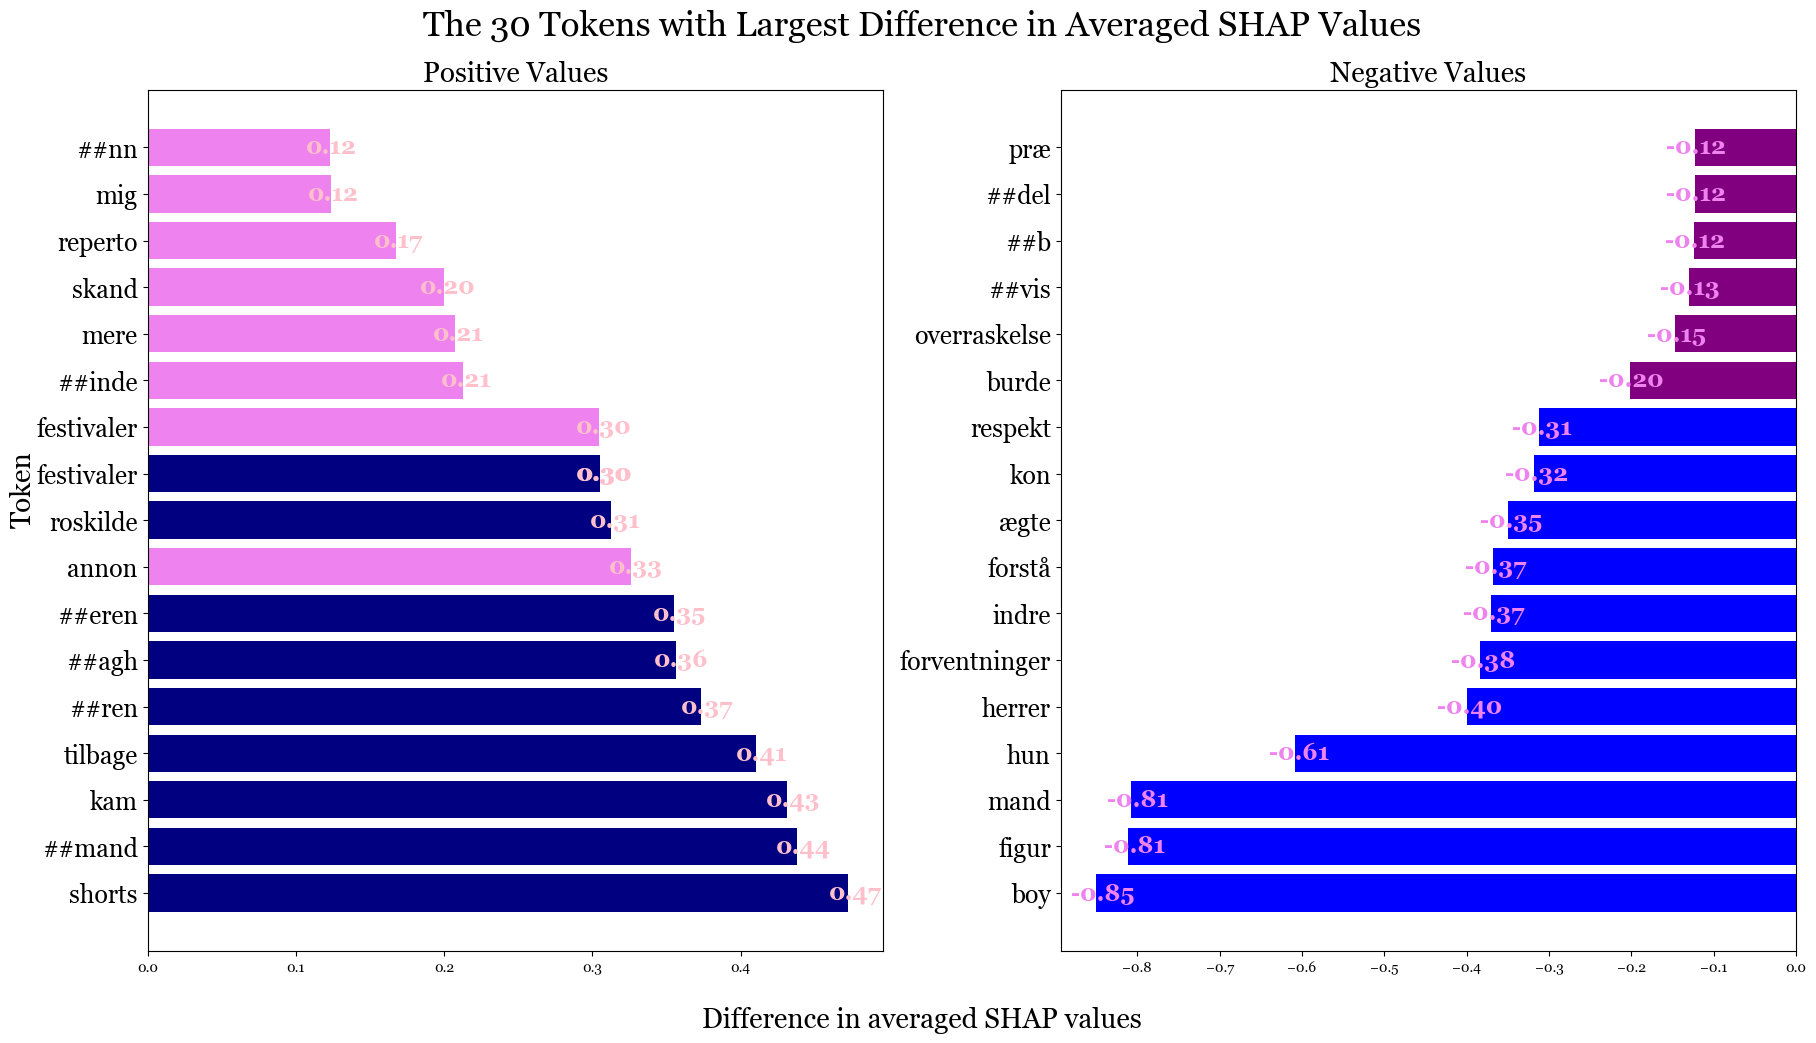

In [367]:
### finetuned::
fem_top_20_dif['gender']='female'
male_top_20_dif['gender']='male'

path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/figures/differentials/fine_top_diff_POSNEG.png'
create_shap_plot(fem_top_20_dif, male_top_20_dif, path, "The 30 Tokens with Largest Difference in Averaged SHAP Values")